# Figure 2

Still a draft.

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import numpy as np
import datetime as dt
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
from scipy import stats
from dask.distributed import Client

In [28]:
client = Client(n_workers=12)
client

Client Scheduler: tcp://127.0.0.1:42477 Dashboard: /proxy/8787/status,Cluster Workers: 12 Cores: 24 Memory: 96.00 GiB


In [2]:
HardDisk = '/g/data/v45/amh157/OCCIPUT/'
EnsembleDir = 'processed_eke/'

In [3]:
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=1.0)

In [4]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries
    n = len(y1)
    nc = int(n/3.5)
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        cor[j], sig[j] = stats.pearsonr(x1t, x2t)
    return cor, sig

## Load and plot ...

To do:
* separate loading and plotting
* legend for panel (a)
* color some key background lines to discuss

In [31]:
## Other things to set
nfiles = 50
col = 'r'
start = dt.datetime(1980,1,1) ## start time for plotting
end = dt.datetime(2014,12,31)

# set latitude bounds - otherwise, use whole SO.
lat1 = -60
lat2 = -40

In [26]:
taufilename = HardDisk+'processed_tau/'+'tau_????.nc'
tau = xr.open_mfdataset(taufilename).tau
    
tau = tau.sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
tau = tau.rolling(time=12,center=True).mean().load()
taup = tau[6:-6] - tau.mean() #Remove first and last 6 months, due to running mean

In [32]:
## Process EKE
eke_results = []
nn=0
for ii in range(1,nfiles+1):
    nn+=1
    i00 = '%03d' % ii
    Member = 'e'+i00
    ekefilename = HardDisk+EnsembleDir+'/eke_'+i00+'_????.nc'
        
    eke = xr.open_mfdataset(ekefilename).EKE
    eke = eke.sel(lat=slice(lat1,lat2)).mean('lon').mean('lat')
    eke = eke.rolling(time=12,center=True).mean().load()

    ekep = eke[6:-6] - eke.mean()
    coef, signif = pearsoncor(taup,ekep)
    
    result = {'ii': ii,'eke': eke,'coef':coef,'signif':signif}
    eke_results.append(result)
    
    if ii==1:
        eke_sum = eke
    else:
        eke_sum = eke_sum + eke
                        
eke_sum = eke_sum.load()/nn

In [34]:
# Compute variance ratios from saved results
for result in eke_results:
    ii = result['ii']
    eke = result['eke']
    if ii==1:
        eke_var = (eke - eke_sum)**2
    else:
        eke_var = eke_var + (eke - eke_sum)**2
        
eke_var = eke_var.load()/nn
sigma2 = np.var(eke_sum)  
epsilon2 = eke_var.mean('time')
ratio = (epsilon2/(epsilon2+sigma2))
print('Whole Southern Ocean: R_i = %0.2f'%ratio.values)

Whole Southern Ocean: R_i = 0.69


In [35]:
# Compute ensemble mean lagged correlation
ekep = eke_sum[6:-6] - eke_sum.mean()
coef_sum, signif_sum = pearsoncor(taup,ekep)
lag = coef_sum.argmax() 

Correlations: 7 months, 0.48, 0.00


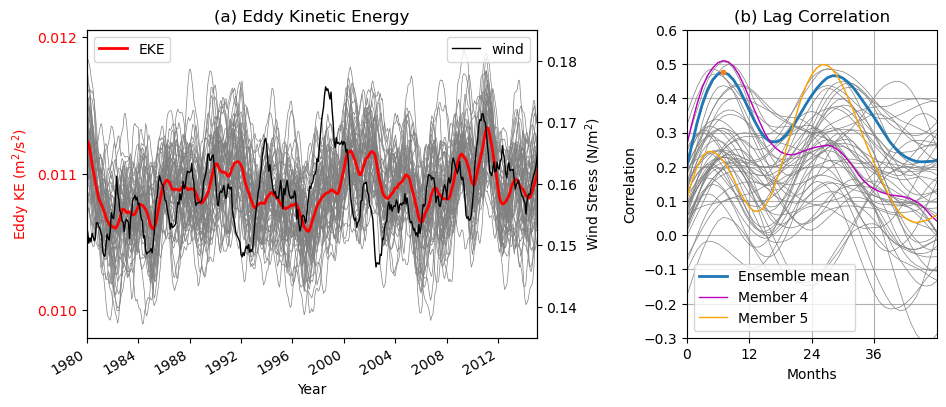

In [60]:
plt.figure(figsize=(10, 4))
ax_eke = plt.axes([0.1,0.13,0.45,0.77])
for result in eke_results:
    ii = result['ii']
    eke = result['eke']
    eke.plot(ax=ax_eke,color=[0.5, 0.5, 0.5],linewidth=0.5)

eke_sum.plot(ax=ax_eke,color=col,linewidth=2,label='EKE')
ax_eke.set_xlabel('Year')
ax_eke.set_ylabel('Eddy KE (m$^2$/s$^2$)',color=col)
#ax_eke.set_ylim(ymax=0.013)
ax_eke.set_yticks([0.01, .011, .012])
ax_eke.tick_params('y',labelcolor=col)
ax_eke.set_xlim([start,end])
ax_eke.set_title('(a) Eddy Kinetic Energy')

plt.legend()

## Axes to plot the wind
ax_tau=ax_eke.twinx()

tau.plot(ax=ax_tau,color='k',linewidth=1,label='wind')
ax_tau.set_ylim([0.135,0.185])
ax_tau.set_ylabel('Wind Stress (N/m$^2$)')
ax_tau.set_xlim([start,end])

plt.legend()
## Axes to plot lagged correlation
ax_corr = plt.axes([0.7,0.13,0.25,0.77])

for result in eke_results:
    ii = result['ii']
    coef = result['coef']
    ax_corr.plot(coef,color=[0.5, 0.5, 0.5],linewidth=0.5)

ax_corr.plot(coef_sum,linewidth=2,label='Ensemble mean')
print('Correlations: %d months, %0.2f, %0.2f'%(lag, coef_sum[lag], signif_sum[lag]))
    
ax_corr.plot(lag,coef_sum[lag],'.')

ax_corr.set_xlim([0,48])
ax_corr.set_ylim([-0.3,0.6])
ax_corr.set_xticks([0, 12, 24, 36])
ax_corr.set_title('(b) Lag Correlation')
ax_corr.set_xlabel('Months')
ax_corr.set_ylabel('Correlation')
ax_corr.grid()

# extra line!!
result = eke_results[3]
#eke = result['eke']
#eke.plot(ax=ax_eke,color='m',linewidth=0.5)
coef = result['coef']
ax_corr.plot(coef,color='m',linewidth=1,label='Member 4')


# extra line!!
result = eke_results[4]
#eke = result['eke']
#eke.plot(ax=ax_eke,color='orange',linewidth=1)
coef = result['coef']
ax_corr.plot(coef,color='orange',linewidth=1,label='Member 5')

plt.legend()

plt.savefig('../paper/figures/Figure2.png',dpi=200)